# AstroCraft PettingZoo Environment Tutorial

This file will serve as a hands-on tutorial for how to use the PettingZoo implementation of the AstroCraft environment. Demonstrated below are the 1v1 and 3v3 game cases.

### Import and initialize the environment

Import the environment from `PettingZoo_MA/env/CaptureTheFlagMA.py`. The `PettingZoo_MA/CaptureTheFlagMA_V0.py` file is empty and was created to preserve similarity with the PettingZoo environment setup guidelines.

The environment is then initialized with values given for the following parameters:

* `team_size`: how many mobile agents (satellites) each time should have

* `win_rew`: the reward the winning team receives (and penalty the losing team incurs) for winning the game via flag capture or elimination of all of the other team's mobiles

* `flag_rew`: an optional reward given for stealing the flag from the opponent's base.

Below, two environments are initialized. env1v1 is a 1v1 game (both sides control 1 satellite) while env3v3 is a 3v3 game (both sides control 3 satellites).

In [1]:
from PettingZoo_MA.env.CaptureTheFlagMA import CTFENVMA
import numpy as np

In [2]:
# 1v1 game environment
env1v1 = CTFENVMA(team_size=1, win_rew=1, flag_rew=0)

#3v3 game environment
env3v3 = CTFENVMA(team_size=3, win_rew=1, flag_rew=0)

### Reset the environment

Like Gymnasium, the environment needs to be reset every time before starting a new game. This is done with the reset() method, which takes no arguments. Also like Gymnasium, the reset method returns two objects: an observation and an info dictionary. Unlike Gymnasium, however, these values for each agent will be returned as a nested dictionary, returning the appropriate values for each player. For example, the observation dictionary will be similar to the following:

{'player0': {'observation': observation, 'action_mask': action_mask}, 'player1': {'observation': observation, 'action_mask': action_mask}}

Where 'observation' is the game state from that agent's point of view, and 'action_mask' is a tuple of arrays which indicate which actions are valid (this will be explained more later).

Note that the 'observation' values for the two players are not identical-- the player's mobiles are first, followed by the opponent's. For example, player0's observation would be:


player0 base

player0 mobiles

player1 base

player1 mobiles


and player1's observation would be:


player1 base

player1 mobiles

player0 base

player0 mobiles


This is to make it more straightforward to train an model to play as either player0 or player1.

In [3]:
obs1v1, info1v1 = env1v1.reset()
print(f"Player 0 Observation: {obs1v1['player0']['observation']}")
print(f"Player 1 Observation: {obs1v1['player1']['observation']}")
print(f"Player 0 Action Mask: {obs1v1['player0']['action_mask']}")
print(f"Player 1 Action Mask: {obs1v1['player1']['action_mask']}")

Player 0 Observation: [[   0.           0.           1.           0.           0.
     0.           0.           0.           0.       ]
 [   0.           1.           1.        1000.           0.
     0.           0.           0.           0.       ]
 [   1.           0.           1.           0.           0.
     0.           0.           0.           3.1415927]
 [   1.           1.           1.        1000.           0.
     0.           0.           0.           3.1415927]]
Player 1 Observation: [[   1.           0.           1.           0.           0.
     0.           0.           0.           3.1415927]
 [   1.           1.           1.        1000.           0.
     0.           0.           0.           3.1415927]
 [   0.           0.           1.           0.           0.
     0.           0.           0.           0.       ]
 [   0.           1.           1.        1000.           0.
     0.           0.           0.           0.       ]]
Player 0 Action Mask: (array([1, 1

In [4]:
obs3v3, info3v3 = env3v3.reset()
print(f"Player 0 Observation: {obs3v3['player0']['observation']}")
print(f"Player 1 Observation: {obs3v3['player1']['observation']}")
print(f"Player 0 Action Mask: {obs3v3['player0']['action_mask']}")
print(f"Player 1 Action Mask: {obs3v3['player1']['action_mask']}")

Player 0 Observation: [[   0.           0.           1.           0.           0.
     0.           0.           0.           0.       ]
 [   0.           1.           1.        1000.           0.
     0.           0.           0.           0.       ]
 [   0.           2.           1.        1000.           0.
     0.           0.           0.           0.       ]
 [   0.           3.           1.        1000.           0.
     0.           0.           0.           0.       ]
 [   1.           0.           1.           0.           0.
     0.           0.           0.           3.1415927]
 [   1.           1.           1.        1000.           0.
     0.           0.           0.           3.1415927]
 [   1.           2.           1.        1000.           0.
     0.           0.           0.           3.1415927]
 [   1.           3.           1.        1000.           0.
     0.           0.           0.           3.1415927]]
Player 1 Observation: [[   1.           0.           1.  

### Take an action

Actions can be selected by any method the user desires, as long as no illegal actions are specified. Actions may be illegal for any of a number of reasons, including (but not limited to):

* Intercept target is not within intercept range
* Mobile does not have sufficient fuel to carry out action
* Mobile is still completing its last action and thus cannot perform a new action
* Mobile has been tagged out

 Passing in an illegal action to the environment will cause an exception to be thrown and terminate the game. To prevent this, an action mask is returned for each individual satellite at each timestep, indicating which actions are currently available for the mobile.

#### Action Mask
The action mask for each player is returned as a tuple of ndarrays with dtype int8, with a separate array for each satellite. This is the required format in order to select an action randomly from the action space via the sample method. A value of 1 at index n in this mask indicates that action n is valid for the given mobile at the current timestep, while a value of 0 in the same position indicates the action in question is invalid. Sampling from the environment's action space can be done in the following way:


`env.action_space(player_name).sample(action_mask)`.


When selecting an action using a custom approach, the user will need to determine how to apply the mask to ensure only valid actions are selected.

At any given time step for any given satellite, most or nearly all of the actions will be illegal. For example, while a satellite is transferring it is unable to take any actions, so the only action available to it is action 0, which is essentially a "continue current trajectory" action.

#### Executing Actions
The ndarrays representing the actions to be taken by each player's mobiles is passed as a dictionary into the step() function of the environment. The step function returns nested dictionaries for observation, reward, termination, truncation, and info values. For example, in the 3v3 case:

`action = {'player0': np.array([1,0,7]), 'player1': np.array([0,0,3])}`

`obs, rew, term, trunc, info = env.step(action)`

NOTE: the observation returned by the step function is of the same format as that returned by the reset function-- that is, it contains an updated action mask for each player. This updated mask will need to be used on the next turn for action selection.

In [5]:
# Actions selected randomly for each player in the 1v1 case
action0 = env1v1.action_space('player0').sample(obs1v1['player0']['action_mask'])
action1 = env1v1.action_space('player1').sample(obs1v1['player1']['action_mask'])

action = {'player0': action0, 'player1': action1}
print(f"Action: {action}")

obs1v1, rew, term, trunc, info = env1v1.step(action)

Action: {'player0': array([5]), 'player1': array([7])}


In [6]:
# Actions selected randomly for each player in the 3v3 case
action0 = env3v3.action_space('player0').sample(obs3v3['player0']['action_mask'])
action1 = env3v3.action_space('player1').sample(obs3v3['player1']['action_mask'])

action = {'player0': action0, 'player1': action1}
print(f"Action: {action}")

obs3v3, rew, term, trunc, info = env3v3.step(action)

Action: {'player0': array([5, 3, 3]), 'player1': array([6, 0, 3])}


### Rendering

A render method has been implemented within the environment to allow for visualization, however it must be called at every step in which a visualization is desired. The function returns a single image snapshot of the game state. The orbitals are pictured, along with the two bases (represented by colored squares), and the satellites (colored triangles when unflagged, colored stars when flagged, colored x's when tagged out or out of fuel).

NOTE: Running both the plotting and the gif creation cells below can cause the kernel to crash. It is recommended to run one or the other, then restart the kernel and run the one you did not run the first time.

In [7]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['figure.dpi'] = 600

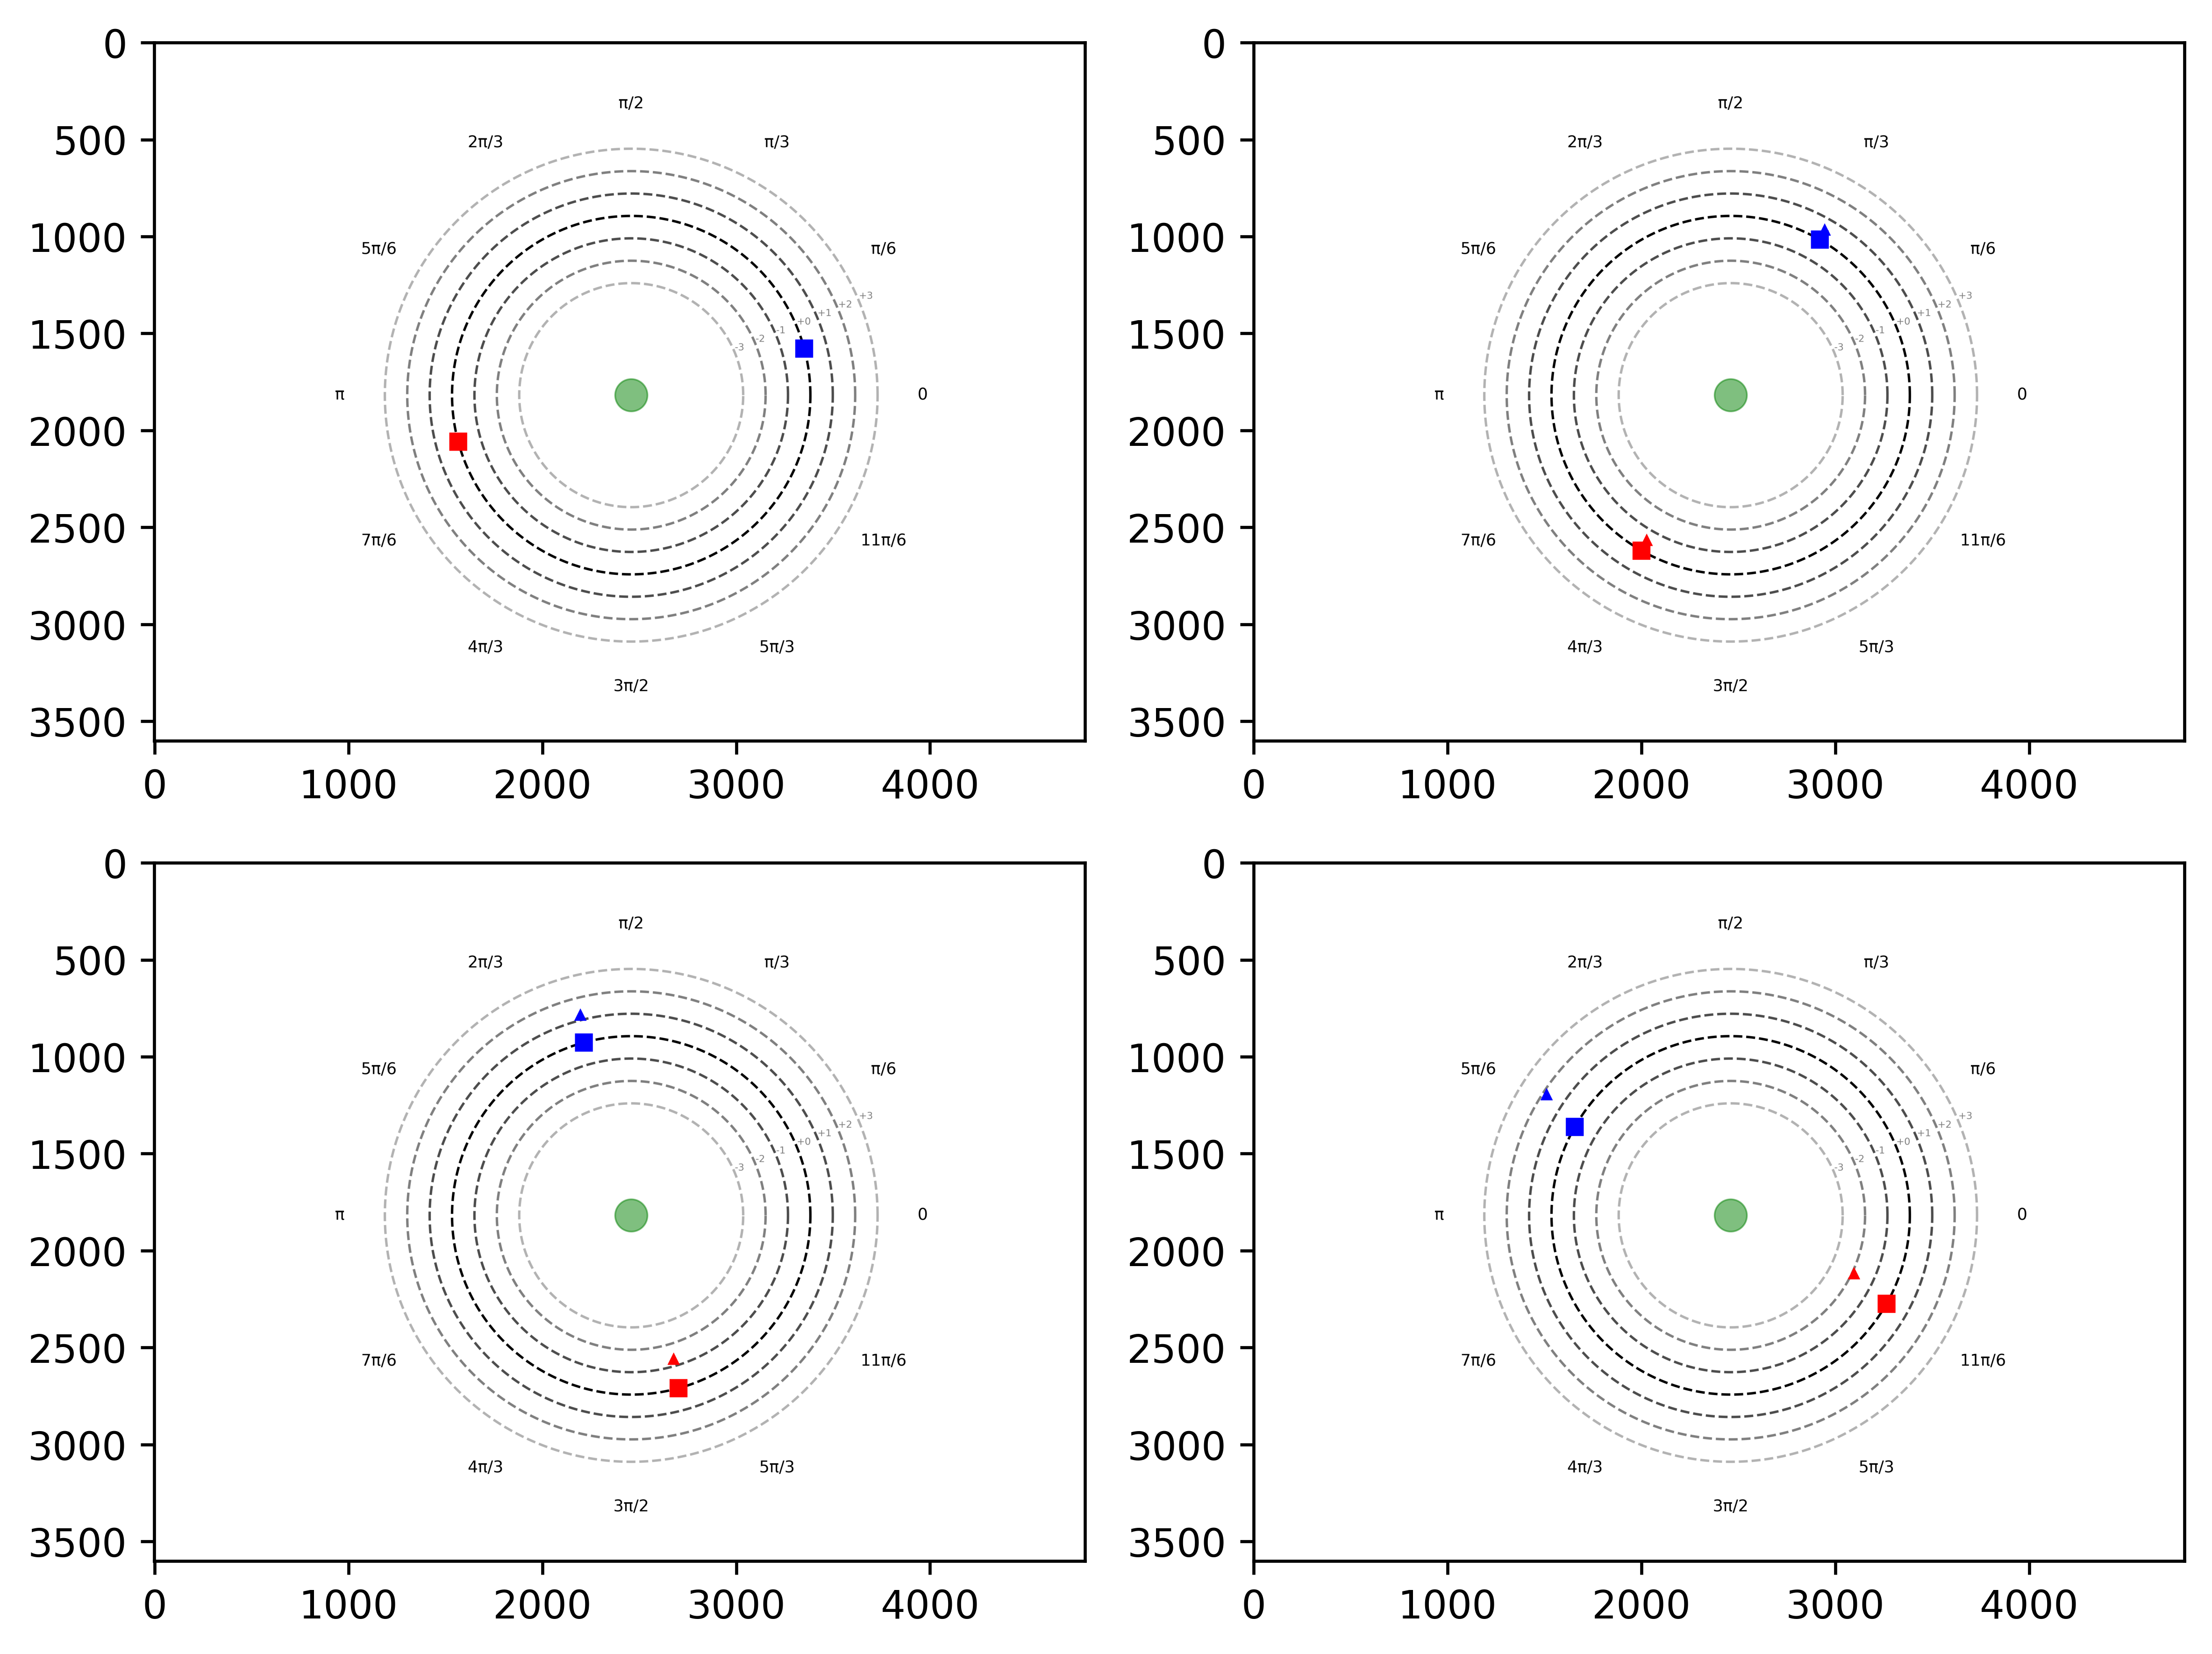

In [8]:
# Several steps are simulated, and the frame renderings plotted in subplots
imgs = []
obs1v1, info1v1 = env1v1.reset()

for _ in range(13):
    action0 = env1v1.action_space('player0').sample(obs1v1['player0']['action_mask'])
    action1 = env1v1.action_space('player1').sample(obs1v1['player1']['action_mask'])
    action = {'player0': action0, 'player1': action1}

    obs1v1, rew, term, trunc, info = env1v1.step(action)

    # Render every 3rd frame
    if _ % 3 == 0:
        imgs.append(env1v1.render())

fig, axs = plt.subplots(2,2)

axs[0,0].imshow(imgs[0])
axs[0,1].imshow(imgs[1])
axs[1,0].imshow(imgs[2])
axs[1,1].imshow(imgs[3])
plt.tight_layout()

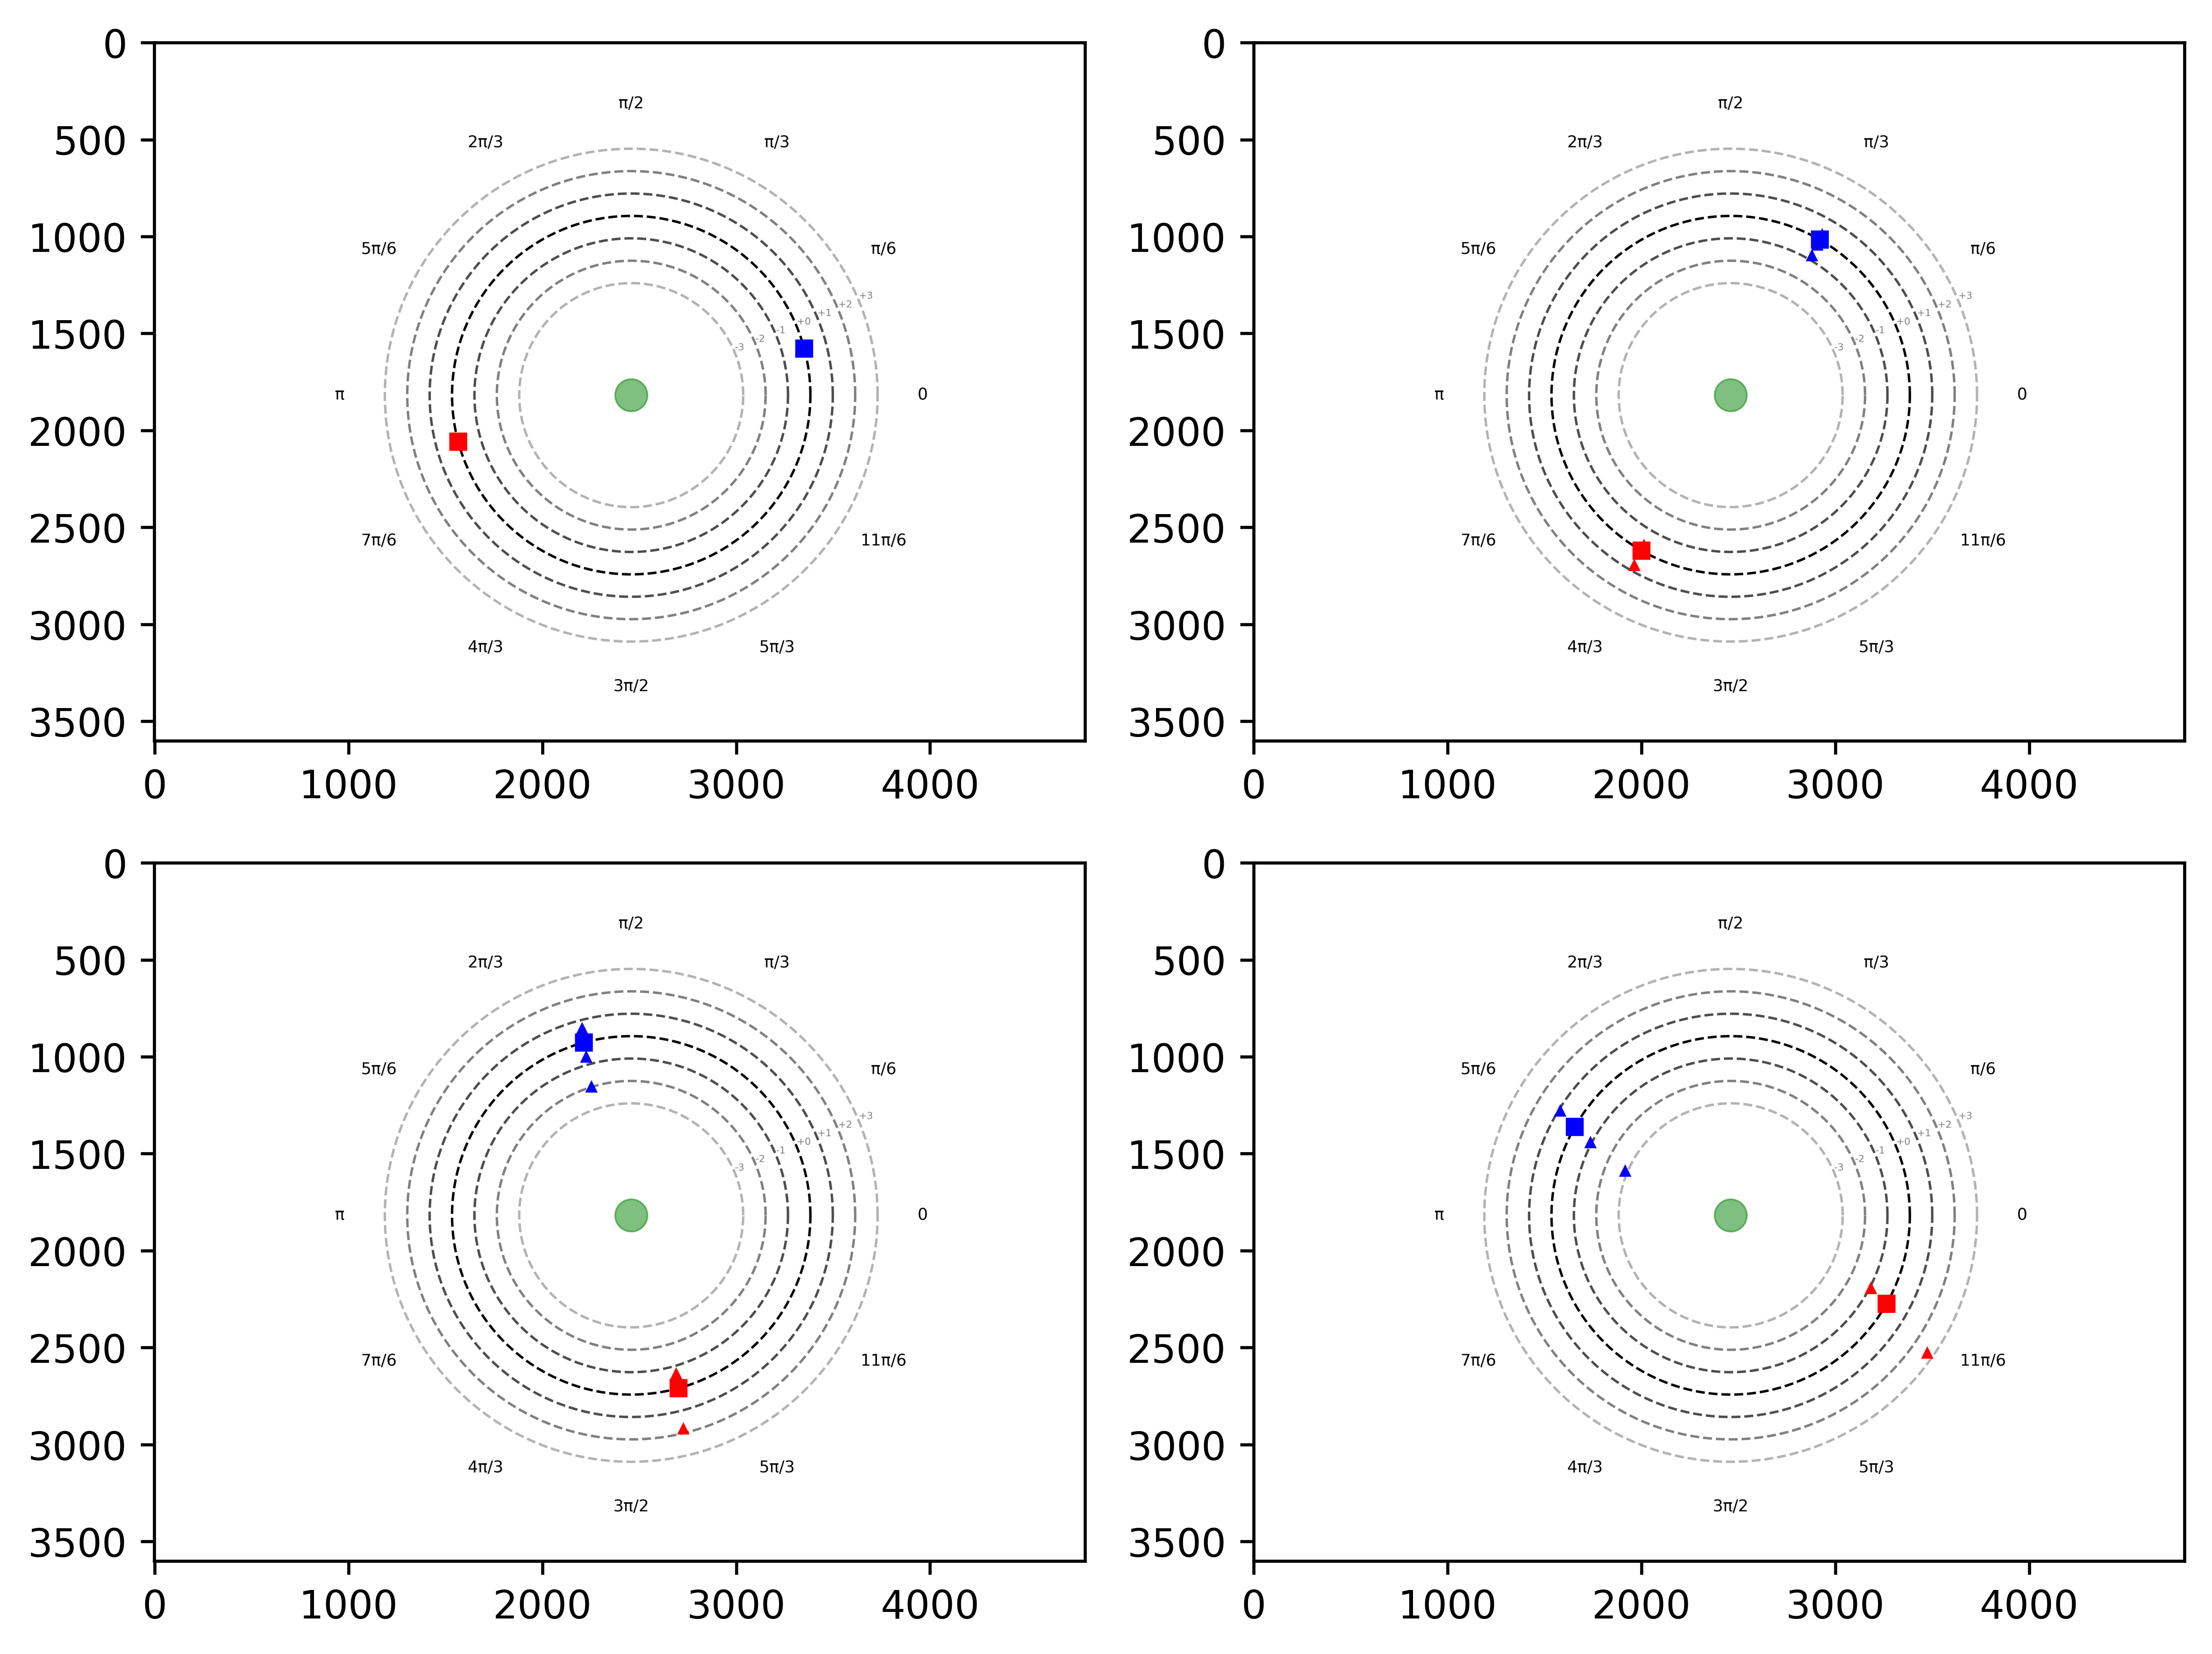

In [9]:
# Several steps are simulated, and the frame renderings plotted in subplots
imgs = []
obs3v3, info3v3 = env3v3.reset()

for _ in range(13):
    action0 = env3v3.action_space('player0').sample(obs3v3['player0']['action_mask'])
    action1 = env3v3.action_space('player1').sample(obs3v3['player1']['action_mask'])
    action = {'player0': action0, 'player1': action1}

    obs3v3, rew, term, trunc, info = env3v3.step(action)

    # Render every 3rd frame
    if _ % 3 == 0:
        imgs.append(env3v3.render())

fig, axs = plt.subplots(2,2)

axs[0,0].imshow(imgs[0])
axs[0,1].imshow(imgs[1])
axs[1,0].imshow(imgs[2])
axs[1,1].imshow(imgs[3])
plt.tight_layout()

Alternatively, animated visualizations can be easily created using the `imageio` library. To do so, simply store the images returned by `env.render()` in a list, and pass that into `imageio.mimsave()` along with a filepath and values for duration (how long each frame is displayed in milliseconds) and loop (how many times the animation should repeat). The animations are saved to the specified filepaths (in the same directory as this tutorial).

In [26]:
import imageio

In [28]:
imgs = []
obs1v1, info1v1 = env1v1.reset()

while True:
    action0 = env1v1.action_space('player0').sample(obs1v1['player0']['action_mask'])
    action1 = env1v1.action_space('player1').sample(obs1v1['player1']['action_mask'])
    action = {'player0': action0, 'player1': action1}
    print(f'Recorded {len(imgs)} turns', end="\r")

    obs1v1, rew, term, trunc, info = env1v1.step(action)
    imgs.append(env1v1.render())
    
    if term['player0'] or term['player1'] or (trunc['player0'] and trunc['player1']):
        break

# By copying the last frame 7 additional times, the end state will be displayed for 2 seconds
imgs.extend([imgs[-1]]*7)

# Each image will be displayed for 1/4 of a second, and the animation will loop twice
imageio.mimwrite('./1v1test.gif', imgs, duration=250, loop=2)

In [29]:
imgs = []
obs3v3, info3v3 = env3v3.reset()

while True:
    action0 = env3v3.action_space('player0').sample(obs3v3['player0']['action_mask'])
    action1 = env3v3.action_space('player1').sample(obs3v3['player1']['action_mask'])
    action = {'player0': action0, 'player1': action1}
    print(f'Recorded {len(imgs)} turns', end="\r")

    obs3v3, rew, term, trunc, info = env3v3.step(action)
    imgs.append(env3v3.render())
    
    if term['player0'] or term['player1'] or (trunc['player0'] or trunc['player1']):
        break

# By copying the last frame 7 additional times, the end state will be displayed for 2 seconds
imgs.extend([imgs[-1]]*7)

# Each image will be displayed for 1/4 of a second, and the animation will loop twice
imageio.mimwrite('./3v3test.gif', imgs, duration=250, loop=2)